# Prosjekt 3. Numeriske beregninger
Skrevet av Johan Solbakken og Aslak Homme.

In [116]:
# Importerer nødvendige bibliotek
import matplotlib.pyplot as plt
import numpy as np

## 1. Innhenting av data

In [98]:
""" Henter en kolonne fra fil og returnerer den som np.array
"""
def read_from_file(filename, column=0):
    array = []
    with open(filename, "r") as f:
        for line in f:
            values = line.split("\t")
            array.append(float(values[column]))
    return np.array(array)

## 2. Datagrunnlag

In [99]:
t_values = read_from_file("rulledata.txt", 0)
x_values = read_from_file("rulledata.txt", 1)

In [100]:
# Tidsdiskretisering
dt = 0.01 # s

# Radien til sirkelbanen
R = 0.45 # meter

# Radien til syllinderen
r = 0.03 # meter

# Gravitasjonskonstanten
g = 9.80665 # meter/sekund/sekund

# Avstand sentrum av sirkelbanen til sentrum syllinder
l = R - r # meter

# Treghetsmomentkonstanten
c = 0.5 

# Massen til syllinderen
m = 2.04 # kg

gamma = 1 / (1+c)
w0 = np.sqrt(gamma * g / l)

# Konvertert x-verdiene til phi-verdier for plotting.
phi_values = np.arcsin(x_values/l)

# Initial-conditions
phi_0 = phi_values[0]
phi_dot_0 = (phi_values[1] - phi_values[0]) / dt

# Forskyvning av normalkraft
d = 0.0000001

beta_bar = 0.000001

phiR = d / r * 2 * w0 / np.pi
beta = 4 * gamma / (3 * np.pi) * w0 * l / m * beta_bar
delta = 0.08

## 3. Løsning av differensiallikning

In [101]:
def f(phi, phi_R, phi_dot, w0, beta, delta, gamma):
    
    a = - w0**2*np.sin(phi)
    b = - 2*delta*phi_dot
    c = - np.pi*phi_R/(2*w0)*(w0**2*np.cos(phi)+gamma*(phi_dot)**2)*np.sign(phi_dot)
    d = - beta*(3*np.pi)*(4*w0)*(phi_dot)**2*np.sign(phi_dot)
    
    phi_double_dot = a + b + c + d
    return phi_double_dot

### 3.1 Euler metoden

In [102]:
def stepEuler(phi, phi_dot, dt, w0, gamma, phiR, delta, beta):
    next_phi = phi + phi_dot*dt
    next_phi_dot = phi_dot + f(phi, phiR, phi_dot, w0, beta, delta, gamma)*dt
    return next_phi, next_phi_dot

### 3.2 Crank-Nicholson-metoden

In [103]:
''' 
NB! Denne kodeblokken inneholder kode dere trenger for å kjøre Crank-Nicholson-metoden.
Det er ikke forventet at dere skal sette dere inn i hva som skjer i denne koden, men dere må klare å bruke den.
'''
def derivative(x, w0, gamma, phiR, delta, beta):
    return np.array([x[1], -w0**2*np.sin(x[0])-(phiR*np.pi/(2*w0))*np.sign(x[1])*(w0**2*np.cos(x[0])+gamma*x[1]**2)-
                  2*delta*x[1]-beta*(3*np.pi/(4*w0))*x[1]**2*np.sign(x[1])])

def findInvJac(x, w0, gamma, phiR, delta, beta, dt):
    f00 = 1
    f01 = -(dt/2)
    f10 = -(dt/2)*(-w0**2*np.cos(x[0])+(phiR*np.pi/(2*w0))*np.sign(x[1])*w0**2*np.sin(x[0]))
    f11 = 1-(dt/2)*(-(phiR*np.pi/(2*w0))*np.sign(x[1])*2*gamma*x[1]-2*delta-2*beta*(3*np.pi/(4*w0))*np.absolute(x[1]) )
    return (1/(f00*f11-f01*f10))*np.array([[f11, -f01], [-f10, f00]])

def findf(x, xPrev, w0, gamma, phiR, delta, beta, dt):
    return x-xPrev-(dt/2)*(derivative(x, w0, gamma, phiR, delta, beta)+derivative(xPrev, w0, gamma, phiR, delta, beta))

def NewtonMethod(x, xPrev, w0, gamma, phiR,delta, beta, dt):
    return x-np.matmul(findInvJac(x, w0, gamma, phiR, delta, beta, dt), findf(x, xPrev, w0, gamma, phiR, delta, beta, dt))

def careFullStep(xPrev, w0, gamma, phiR, delta, beta, dt, n):
    nIntervalls = n
    dt = dt/nIntervalls

    k = np.empty((4, 2))
    x = np.empty((2, 2))
    x[0] = np.copy(xPrev)
    for i in range(nIntervalls):
        k[0] = derivative(x[0], w0, gamma, phiR, delta, beta)
        x[1] = x[0]+(dt/2)*k[0]
        k[1] = derivative(x[1], w0, gamma, phiR, delta, beta)
        x[1] = x[0]+(dt/2)*k[1]
        k[2] = derivative(x[1], w0, gamma, phiR, delta, beta)
        x[1] = x[0]+dt*k[2]
        k[3] = derivative(x[1], w0, gamma, phiR, delta, beta)
        x[0] += (dt/6)*(k[0]+2*k[1]+2*k[2]+k[3])
    return x[0]

def stepCN(phi, phidot, dt, w0, gamma=1., phiR=0., delta=0., beta=.0):
    xPrev = np.array([phi, phidot])
    x = xPrev+dt*derivative(xPrev, w0, gamma, phiR, delta, beta)
    counter = 0
    tol=1e-15 # Tolerance of Newtons method, default value 1e-15
    while np.amax(np.absolute((findf(x, xPrev, w0, gamma, phiR, delta, beta, dt)))) > tol or counter < 1:
        if (np.sign(x[1] * xPrev[1]) == -1) and counter > 2 :
            return careFullStep(xPrev, w0, gamma, phiR, delta, beta, dt, 10)   #, -1
        x = NewtonMethod(x, xPrev, w0, gamma, phiR, delta, beta, dt)
        counter += 1
        if counter >= 10:
            return careFullStep(xPrev, w0, gamma, phiR, delta, beta, dt, 100)   #, -2
    return x[0], x[1]   #, counter

### 3.3 ODE-solver

In [104]:
def ODE_solver(dt, t_0, t_end, phi_0, phi_dot_0, w0, phiR, delta, beta, gamma, step_func=stepEuler):
    ts = np.arange(t_0, t_end, dt)
    phis = np.zeros_like(ts)
    phi_dots = np.zeros_like(ts)
    
    phis[0], phi_dots[0] = phi_0, phi_dot_0

    for i, t in enumerate(ts[:-1]): #now repeat CN(phi, phidot, dt, w0, gamma=1., phiR=0., delta=0., beta=.0):
        phis[i+1], phi_dots[i+1] = step_func(phis[i], phi_dots[i], dt, w0, gamma, phiR, delta, beta)
    return ts, phis, phi_dots

### 3.4 Plotting function for CN-method in terms of phi, delta and beta

In [105]:
""" CN_metode
"""
def CN_metode_plot(beta=4 * gamma / (3 * np.pi) * w0 * l / m * .000001, phiR=d / r * 2 * w0 / np.pi, delta=0.08, title='Kart'):
    ts, phis, phi_dots = ODE_solver(dt, t_values[0], t_values[-1], phi_0, phi_dot_0, w0, phiR, delta, beta, gamma, step_func=stepCN)
    plt.figure(3)
    plt.title(f'Numerisk CN-metode gjett: $\phi_R={phiR}, \\beta={beta}, \\delta={delta}$')
    plt.plot(t_values, phi_values * 3.5) # scale by 30
    plt.plot(ts, phis)
    plt.xlabel("Tid")
    plt.ylabel("Vinkelutslag")
    plt.legend(['Scaled phi-values calculated from x-values', 'Numerical solution'])
    plt.savefig(title)

## 4. Plotting

### 4.1 Analytic solution

Text(0, 0.5, 'Vinkelutslag')

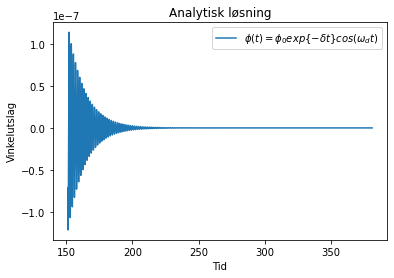

In [106]:
def phi_analytic(t, phi0, w0, delta):
    return phi0*np.exp(-delta*t)*np.cos(np.sqrt(w0**2-delta**2)*t)

plt.title("Analytisk løsning")
plt.plot(t_values, phi_analytic(t_values, phi_0, w0, delta))
plt.legend(["$\phi(t)=\phi_0 exp\{-\delta t\}cos(\omega_d t)$"])
plt.xlabel("Tid")
plt.ylabel("Vinkelutslag")

### 4.2 Eulers method

Text(0, 0.5, 'Vinkelutslag')

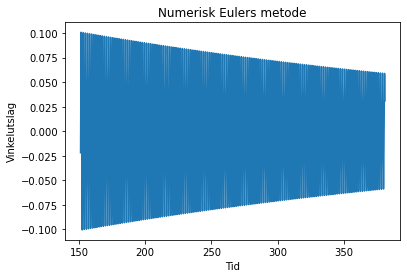

In [107]:
""" Eulers metode
"""
t_num_array, phi_num_array, phi_dot_num_array = ODE_solver(dt, t_values[0], t_values[-1], phi_0, phi_dot_0, w0, phiR, delta, beta, gamma)
plt.figure(2)
plt.title("Numerisk Eulers metode")
plt.plot(t_num_array, phi_num_array)
plt.xlabel("Tid")
plt.ylabel("Vinkelutslag")

### 4.3 Initial guess

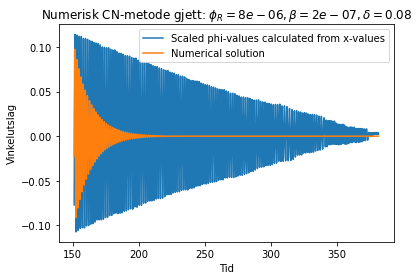

In [108]:
CN_metode_plot(phiR=8e-06, beta=2e-07, delta=8e-02, title='initialGuess.pdf')

### 4.4 High delta value

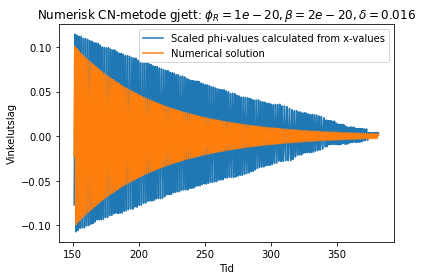

In [110]:
CN_metode_plot(phiR=1e-20, beta=2e-20, delta=16e-03, title='onlyHighDelta.pdf')

### 4.5 High beta value

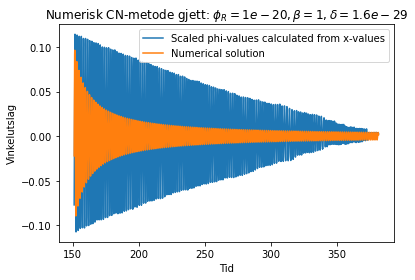

In [115]:
CN_metode_plot(phiR=1e-20, beta=1, delta=16e-30, title='onlyHighBeta.pdf')

### 4.6 High phi_R

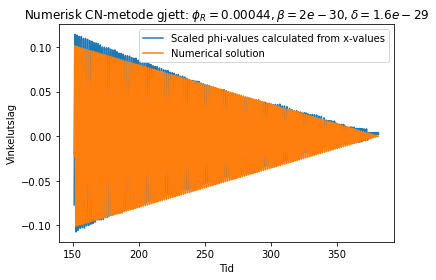

In [112]:
CN_metode_plot(phiR=44e-5, beta=2e-30, delta=16e-30, title='onlyHighPhiR.pdf')